<a href="https://colab.research.google.com/github/dd-open-source/ml-projects/blob/main/transfer_learning/Ships/Ship_classification_using_transfer_learning_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our solution for [Analytics Vidhya Hackathon](https://datahack.analyticsvidhya.com/contest/game-of-deep-learning/) using pickle to store all images as single file. This reduced training time from 20 mins to 20 seconds.

In [ ]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.3 MB/s 


### Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet_v2, densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import files
import pickle
import io
import tensorflow_addons as tfa


### Defines reusable constants

In [ ]:
# Data files: 
# Google drive: https://drive.google.com/file/d/1x5XrLOEhiwNO_hJLMFbfdrPQDEymki5z/view
# Download the above data files from our google drive 
# to your google drive or local computer and update the below paths accordingly

project_folder = '/content/drive/MyDrive/ML_Projects/Ships'
data_dir = path.join(project_folder, 'data')
models_path =path.join(project_folder, 'models')
models_dir = path.join(models_path, "base")
train_csv_path = path.join(data_dir, 'train.csv')
test_csv_path = path.join(data_dir, 'test.csv')
label_col = 'category_name'
category_id_col = "category"
image_names_col = 'image'
image_idx_col = 'image_idx'
images_dir = path.join(data_dir, "images")
imgy = imgx = 320
submission_csv_path = path.join(data_dir, 'submission.csv')
categories_name_to_id = {'Cargo': 1,  'Military': 2,  'Carrier': 3, 'Cruise': 4, 'Tankers': 5}
categories_id_to_name = { value:key for key,value in categories_name_to_id.items()}
images_dump_path = path.join(data_dir, 'images.pkl')
BATCH_SIZE = 32

Define common functions

In [ ]:
def get_image_id(img_name):
    return int(img_name[:-4])

def get_image(img_name, images_dump=None, images_name_to_id=None):
    if images_dump is not None and images_name_to_id is not None:
      img_path = io.BytesIO(images_dump[images_name_to_id[img_name]])
    else:
      img_path = path.join(images_dir, img_name)
    return Image.open(img_path)

# Shows a randomly selected images from data
def showImages(df, n=1, images_dump=None, images_name_to_id=None):
    cols = 5
    rows = max(1, n//cols)
    sample = df.sample(n=n).reset_index(drop=True)
    for idx, row in sample.iterrows():
      img = get_image(row[image_names_col], images_dump, images_name_to_id)
      plt.subplot(rows, cols, idx+1)
      plt.title(row[label_col])
      plt.imshow(img)
    plt.figure(figsize=(10, 20))
    plt.show()


def get_file_bytes(parenet_dir, file_name):
  with open(path.join(parenet_dir, file_name), 'rb') as f:
    return f.read()

def dump_files_as_pickle(parent_dir, dump_file_path):
  if path.exists(dump_file_path):
    print("Dump file exists so skipping")
    return
  file_names = listdir(parent_dir)
  files_dump = []
  for file_name in file_names:
    files_dump.append(get_file_bytes(parent_dir, file_name))

  files_dict = {"parent_dir": parent_dir, "file_names": file_names, "files_dump": files_dump}
  with open(dump_file_path, 'wb') as fh:
    pickle.dump(files_dict, fh)

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
  # Unpack two datasets
  images_one, labels_one = ds_one
  images_two, labels_two = ds_two
  batch_size = tf.shape(images_one)[0]

  # Sample lambda and reshape it to do the mixup
  l = sample_beta_distribution(batch_size, alpha, alpha)
  x_l = tf.reshape(l, (batch_size, 1, 1, 1))
  y_l = tf.reshape(l, (batch_size, 1))

  # Perform mixup on both images and labels by combining a pair of images/labels
  # (one from each dataset) into one image/label
  images = images_one * x_l + images_two * (1 - x_l)
  labels = labels_one * y_l + labels_two * (1 - y_l)
  return (images, labels)

def create_images_dataset(images_tensor, df, training=False):
  def generate_random_angle():
    return tf.random.uniform([], 0, 20)*np.pi/180

  def augment_image(img):
    img = tfa.image.rotate(img, generate_random_angle(), fill_mode='nearest')
    img = tf.image.random_flip_left_right(img)
    return img

  def extract_image(img_idx):
    image_string = images_tensor[img_idx]
    img = tf.image.decode_jpeg(image_string, channels=3)
    return tf.image.resize(img, [imgy, imgx], antialias=True)

  ds = tf.data.Dataset.from_tensor_slices(df[image_idx_col])
  ds = ds.map(extract_image)
  if training:
    ds = ds.map(augment_image)
  return ds

def create_labels_dataset(df):
  one_hot_tensor = tf.one_hot(tf.range(5), 5)
  def convert_label_to_one_hot_tensor(label):
    # Our label index starts with 1
    return one_hot_tensor[label-1]
  label_ds = tf.data.Dataset.from_tensor_slices(df[category_id_col])
  return  label_ds.map(convert_label_to_one_hot_tensor)

def create_dataset_with_labels(images_tensor, df, training=False):
  img_ds = create_images_dataset(images_tensor, df, training=training)
  label_ds = create_labels_dataset(df)
  ds = tf.data.Dataset.zip((img_ds, label_ds))
  if training:
    ds = ds.shuffle(BATCH_SIZE*100)
  return ds.batch(BATCH_SIZE)

In [ ]:
dump_files_as_pickle(images_dir, images_dump_path)

Dump file exists so skipping


### Load data

In [ ]:
with open(images_dump_path, "rb") as f:
  images_dump = pickle.load(f)
images_name_to_id = { name:idx for idx, name in enumerate(images_dump['file_names'])}
print("images_dump keys", images_dump.keys(), "\nnum image files", len(images_dump['file_names']))

train_df = pd.read_csv(train_csv_path)
train_df[label_col] = train_df[category_id_col].map(categories_id_to_name)
train_df[image_idx_col] = train_df[image_names_col].map(images_name_to_id)
test_df = pd.read_csv(test_csv_path)
test_df[image_idx_col] = test_df[image_names_col].map(images_name_to_id)

train_df.head()

images_dump keys dict_keys(['parent_dir', 'file_names', 'files_dump']) 
num image files 8932


,image,category,category_name,image_idx
0,2823080.jpg,1,Cargo,3735
1,2870024.jpg,1,Cargo,5246
2,2662125.jpg,2,Military,8426
3,2900420.jpg,3,Carrier,8637
4,2804883.jpg,2,Military,6320


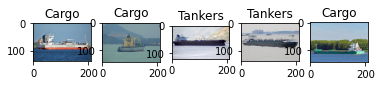

<Figure size 720x1440 with 0 Axes>

In [ ]:
showImages(train_df, n=5, images_dump=images_dump['files_dump'], images_name_to_id=images_name_to_id)

Prepare images dump tensors

In [ ]:
all_images_tensor = tf.convert_to_tensor(images_dump['files_dump'])

### Prepare datasets for training and validation

In [ ]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
# Mixup training images
train_ds1 = create_dataset_with_labels(all_images_tensor, train_data, training=True)
train_ds2 = create_dataset_with_labels(all_images_tensor, train_data, training=True)
train_ds = tf.data.Dataset.zip((train_ds1, train_ds2)).map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds = create_dataset_with_labels(all_images_tensor, val_data).prefetch(tf.data.AUTOTUNE)
test_ds = create_images_dataset(all_images_tensor, test_df).batch(BATCH_SIZE)

# Let's preview 9 samples from the dataset
plt.figure(figsize=(10, 10))
for sample in train_ds.take(1):
  for (image, label) in zip(sample[0][:9], sample[1][:9]):
      plt.imshow(image.numpy().squeeze().astype(np.uint8))
      print(label.numpy())
      plt.axis("off")
      plt.show()


### Training deep neaural network using Tensorflow

**Transfer learning**: We are using ResNet model for image classification.
1. In 1st phase, we train our model by freezing keeping pre_trained_model (i.e setting trainable=False)
1. In 2nd phase, we train our model by unfreezing keeping pre_trained_model (i.e setting trainable=True) but with very small learning_rate

In [ ]:
class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

def create_model(trainable=False):
    pre_trained_model = densenet.DenseNet169(include_top=False, pooling='max', weights='imagenet', input_shape=(imgy, imgx, 3))
    input = tf.keras.Input(shape=(imgy, imgx, 3))
    output = resnet_v2.preprocess_input(input)
    output = pre_trained_model(output, training=False)
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(5, activation="softmax")(output)
    pre_trained_model.trainable=trainable
    model = tf.keras.Model(input, output)
    return model


def compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=0.01, epochs=5, patience=3, current_best_model=None):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=patience, mode='max')
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_f1_score',
                                                                  mode='max', save_weights_only=True, save_best_only=True)
  callbacks = [early_stopping, model_checkpoint_callback]

  optimizers = [
      tf.keras.optimizers.Adam(learning_rate=1e-4),
      tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.CosineDecay(learning_rate, 2000, 1e-4))
  ]
  optimizers_and_layers = [(optimizers[0], model.layers[:-1]), (optimizers[1], model.layers[-1])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tfa.metrics.F1Score(5, average="weighted")], optimizer=optimizer)
  
  if current_best_model is not None:
    model.set_weights(current_best_model.get_weights())

  train_log = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
  best_model = create_model()
  best_model.load_weights(tf.train.latest_checkpoint(models_dir))
  return best_model, train_log


**Find best learning rate**

150/150 [==============================] - 27s 56ms/step - loss: 12.4876 - accuracy: 0.3250


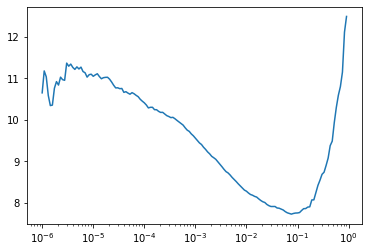

In [ ]:
EPOCHS = 1
BATCH_SIZE = 32
lr_finder_steps = 150
lr_find = LRFind(1e-6, 1, lr_finder_steps)
model = create_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], 
                  optimizer="Adamax")
model.fit(
    train_ds,
    steps_per_epoch=lr_finder_steps,
    epochs=EPOCHS,
    callbacks=[lr_find]
)

plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()

Best learning rate is  between 0.01 to 0.1 from the graph and let us select lr as 0.01 to on safe side

Fast training phase by freezing the pre-trained-model and followed by 
slow training phase by unfreezing the pre-trained model.

In [ ]:
model = create_model()
print(model.summary())
model_path = path.join(models_dir, "best")
print("We start with higher learning rate and gradually decrease it as we train more and more")
# Training takes less time so we can run for more epochs
best_fast_model, train_log = compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=0.1, epochs=30, patience=5)
best_model, train_log = compile_and_fit(create_model(trainable=True), train_ds, val_ds, model_path, learning_rate=1e-4, epochs=30,
                                        patience=5, current_best_model=best_fast_model)

#### Check results on test dataset

In [ ]:
# Create best model from saved weights
test_predictions = best_model.predict(test_ds)
# Our label index starts with 1
test_df[category_id_col] = pd.Series(np.argmax(test_predictions, axis=1)+1)
test_df[label_col] = test_df[category_id_col].map(categories_id_to_name)

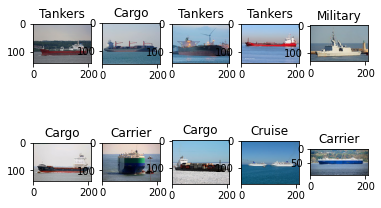

<Figure size 720x1440 with 0 Axes>

In [ ]:
showImages(test_df, n=10, images_dump=images_dump['files_dump'], images_name_to_id=images_name_to_id)

**Create Submission file**

In [ ]:
test_df[[image_names_col, category_id_col]].to_csv(submission_csv_path, index=False)
files.download(submission_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>